# Experiment 4: Independent Content and Motion Interpolation

This experiment demonstrates that we can interpolate in content and motion spaces **independently**.

Key experiments:
1. **Content interpolation with fixed motion**: Morph between digits while maintaining same motion
2. **Motion interpolation with fixed content**: Change motion style while keeping same digits


In [6]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import os

from data import get_moving_mnist_dataloaders
from models import DisentangledVAE
from utils import plot_interpolation, plot_video_frames

# Set device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")


Using device: mps


In [7]:
# Load model
model = DisentangledVAE(content_dim=128, motion_dim=128).to(device)

checkpoint_path = '../checkpoints/disentangled_vae/best_model.pt'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("✓ Model loaded")
else:
    print("✗ Train the model first!")


✓ Model loaded


In [11]:
# Get test data
_, _, test_loader = get_moving_mnist_dataloaders(
    batch_size=16, train_size=100, val_size=50, test_size=100, num_workers=0, seed=42
)
videos, metadata = next(iter(test_loader))
videos = videos.to(device)

# Select two videos for interpolation
video1 = videos[10:11]
video2 = videos[11:12]

print(f"Video 1 digits: {metadata[0]['labels']}")
print(f"Video 2 digits: {metadata[1]['labels']}")


Video 1 digits: [np.int64(2), np.int64(6)]
Video 2 digits: [np.int64(2), np.int64(5)]


## Content Interpolation (Fixed Motion)

Morph between two digit identities while keeping motion constant.


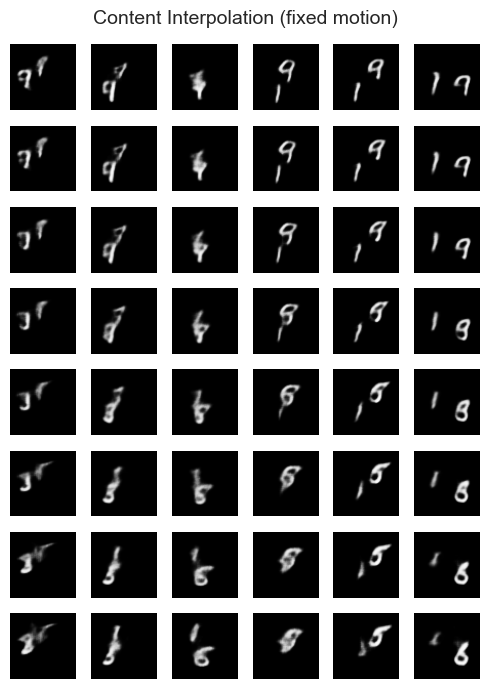

In [16]:
# Content interpolation (motion from video 1)
model.eval()
content_interp = model.interpolate_content(video1, video2, num_steps=8, use_motion_from='first')

# Visualize
fig = plot_interpolation(
    content_interp, 
    num_frames=6,
    title=f"Content Interpolation (fixed motion)",
    figsize=(5, 7)  # Make the figure a bit smaller than default
)
plt.savefig('../results/figures/content_interpolation.png', dpi=150, bbox_inches='tight')
plt.show()


## Motion Interpolation (Fixed Content)

Transition between two motion patterns while keeping digit identity constant.


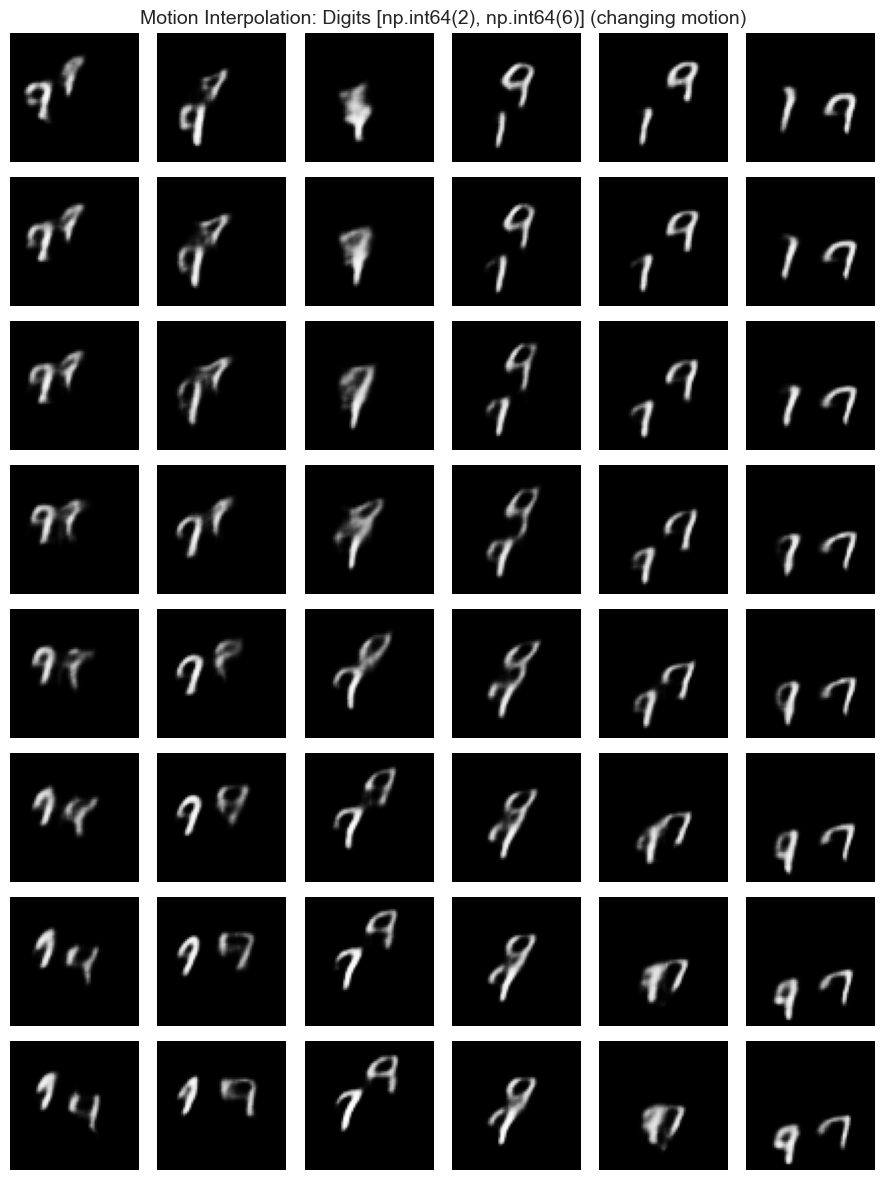

In [13]:
# Motion interpolation (content from video 1)
motion_interp = model.interpolate_motion(video1, video2, num_steps=8, use_content_from='first')

# Visualize
fig = plot_interpolation(
    motion_interp, 
    num_frames=6,
    title=f"Motion Interpolation: Digits {metadata[0]['labels']} (changing motion)"
)
plt.savefig('../results/figures/motion_interpolation.png', dpi=150, bbox_inches='tight')
plt.show()


## Summary

### Key Findings:
1. **Content interpolation** shows smooth morphing between digit identities while motion remains consistent
2. **Motion interpolation** shows smooth transition between motion patterns while digits remain recognizable

### Research Significance:
This independent interpolation capability is only possible because of the explicit disentanglement in our architecture. Standard VAEs would entangle these factors, making independent control impossible.

### Implications:
- Enables fine-grained control over video generation
- Demonstrates true disentanglement of content and motion
- Supports the hypothesis that explicit architectural separation is beneficial
